In [24]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy as sp
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Basic Parameterized Quantum Circuit

In [25]:
a, b = sp.symbols('a b')

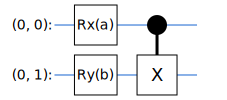

In [26]:
# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create circuit on these qubits using params `a` and `b`
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1)
)

SVGCircuit(circuit)

## Circuit Evaluation

In [27]:
# Calculate a state vector with a=0.5, b=-0.5
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})

output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state
output_state_vector

array([ 0.9387913 +0.j        , -0.23971277+0.j        ,
        0.        +0.06120872j,  0.        -0.23971277j], dtype=complex64)

### Pauli $\hat Z_0$ Measurement on State Vector

In [28]:
z0 = cirq.Z(q0)

qubit_map = {q0: 0, q1: 1}

z0.expectation_from_wavefunction(output_state_vector, qubit_map).real

0.8775825500488281

### Pauli $\frac{1}{2} \hat Z_0 + \hat X_1$ Measurement on State Vector

In [29]:
z0x1 = 0.5 * z0 + cirq.X(q1)

z0x1.expectation_from_wavefunction(output_state_vector, qubit_map).real

-0.04063427448272705

In [30]:
# Rank 1 tensor containing 1 circuit
circuit_tensor = tfq.convert_to_tensor([circuit])

print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [31]:
# Rank 1 tensor containing 2 Pauli operators
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape

TensorShape([2])

In [32]:
# batch of values to sub for `a` and `b` parameters
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=np.float32)

cirq_results = []
cirq_simulator = cirq.Simulator()

for val in batch_vals:
    resolver = cirq.ParamResolver({a: val[0], b: val[1]})
    final_state = cirq_simulator.simulate(circuit, resolver).final_state
    cirq_results.append(
        [z0.expectation_from_wavefunction(final_state, {
            q0: 0,
            q1: 1
        }).real])
    
print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.40864956]
 [-0.84766239]
 [ 0.41367596]
 [ 0.69389665]
 [ 0.76356912]]


# Hybrid Neural Network

## Controlled Circuit

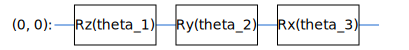

In [33]:
# Parameters that the classical Nn will feed values into
control_params = sp.symbols('theta_1 theta_2 theta_3')

# Create parameterized circuit
qubit = cirq.GridQubit(0, 0)

model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit)
)

SVGCircuit(model_circuit)

## Controller

In [34]:
# Classical neural network layers
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.52638555,  1.0509732 , -0.26381436]], dtype=float32)

## Controller-Circuit Connection

In [35]:
# Simulated miscalibration that model will learn to correct
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.string,
                                name='circuits_input')

# Set qubits' state to `0` or `1` based on command
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

Apply operations to above inputs to define the computation:

In [36]:
dense_2 = controller(commands_input)

# TFQ layer for classically controlled circuits
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))
expectation = expectation_layer([circuits_input, dense_2])

Package computation as Keras model:

In [37]:
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

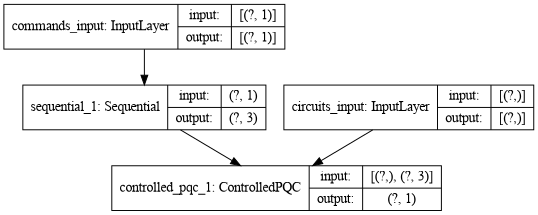

In [38]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

In [39]:
# Command input values to the classical NN
commands = np.array([[0], [1]], dtype=np.float32)

# Desired Z expectation value at output of quantum circuit
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [40]:
# Input circuit that defines random miscalibration the model will learn to correct
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
datapoint_circuits = tfq.convert_to_tensor([
  noisy_preparation
] * 2)  # Make two copied of this circuit

# datapoint_circuits.shape # 2 copies of circuit; 1 copy for each datapoint

# Dry run of tfq model
model([datapoint_circuits, commands]).numpy()

array([[0.6260606 ],
       [0.56155056]], dtype=float32)

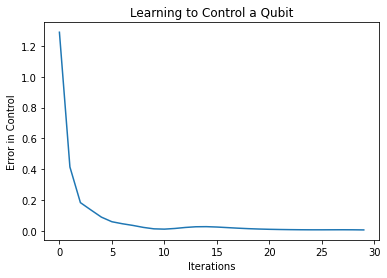

In [41]:
# Run training process to adjust output values towards `expected_outputs`
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

# Plot training information
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

## Verify Outputs

Use the trained model to correct the qubit calibration errors.

In [44]:
def check_error(command_values, desired_values):
  """Based on the value in `command_value` see how well you could prepare
  the full circuit to have `desired_value` when taking expectation w.r.t. Z."""
  params_to_prepare_output = controller(command_values).numpy()
  full_circuit = noisy_preparation + model_circuit

  # Test how well you can prepare a state to get the expectation
  # value in `desired_values`
  for index in [0, 1]:
    state = cirq_simulator.simulate(
        full_circuit,
        {s:v for (s,v) in zip(control_params, params_to_prepare_output[index])}
    ).final_state
    expectation = z0.expectation_from_wavefunction(state, {qubit: 0}).real
    print(f'For a desired output (expectation) of {desired_values[index]} with'
          f' noisy preparation, the controller\nnetwork found the following '
          f'values for theta: {params_to_prepare_output[index]}\nWhich gives an'
          f' actual expectation of: {expectation}\n')


check_error(commands, expected_outputs)

For a desired output (expectation) of [1.] with noisy preparation, the controller
network found the following values for theta: [ 0.0254344  -0.88573796 -0.6036245 ]
Which gives an actual expectation of: 0.9438512325286865

For a desired output (expectation) of [-1.] with noisy preparation, the controller
network found the following values for theta: [0.9268755  2.6368454  0.11764073]
Which gives an actual expectation of: -0.9295072555541992

